# Import Libraries

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import random
from sklearn.preprocessing import StandardScaler

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

# Read Dataset

In [70]:
#Read datasets
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')
X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')
#Read test datasets
X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

In [60]:
X_train_observed_a.head(20)

,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms
0,2019-06-02 22:00:00,7.7,1.230,1744.900024,0.000000,0.000000,1744.900024,0.0,280.299988,0.000000,0.000000,0.0,0.000000,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0
1,2019-06-02 22:15:00,7.7,1.229,1734.000000,0.000000,0.000000,1734.000000,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,NaN,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0
2,2019-06-02 22:30:00,7.7,1.228,1723.500000,0.000000,0.000000,1723.500000,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,NaN,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0
3,2019-06-02 22:45:00,7.7,1.226,1713.400024,0.000000,0.000000,1713.400024,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,NaN,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0
4,2019-06-02 23:00:00,7.7,1.225,1703.599976,0.000000,0.000000,1703.599976,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0
5,2019-06-02 23:15:00,7.7,1.224,1694.199951,0.000000,0.000000,1694.199951,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.299988,0.0,0.0,992.799988,998.799988,0.0,0.0,68.400002,1004.799988,NaN,0.0,0.0,-0.0,0.2,0.235000,-4.438,0.0,286.899994,100.000000,36427.199219,3.4,-3.4,0.2,-0.0
6,2019-06-02 23:30:00,7.7,1.223,1685.099976,0.000000,0.000000,1685.099976,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.800003,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.099976,0.0,0.0,992.599976,998.500000,0.0,0.0,67.599998,1004.500000,NaN,0.0,0.0,-0.0,0.2,3.728000,-4.379,0.0,286.899994,100.000000,31136.000000,3.3,-3.3,0.4,-0.0
7,2019-06-02 23:45:00,7.7,1.222,1676.400024,0.000000,0.000000,1676.400024,0.0,280.299988,0.000000,0.000000,0.0,0.000000,99.900002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.900024,0.0,0.0,992.299988,998.299988,0.0,0.1,66.800003,1004.299988,NaN,0.0,0.0,-0.0,0.2,7.218000,-4.219,0.0,287.000000,100.000000,25819.500000,3.2,-3.2,0.5,-0.0
8,2019-06-03 00:00:00,7.7,1.221,1668.099976,0.000000,0.000000,1668.099976,0.0,280.200012,0.000000,0.000000,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.599976,0.0,0.0,992.099976,998.099976,0.0,0.1,66.000000,1004.099976,NaN,0.0,0.0,-0.0,0.2,9.741000,-3.910,0.0,287.000000,100.000000,20473.000000,3.2,-3.1,0.7,-0.0
9,2019-06-03 00:15:00,7.8,1.220,1598.199951,0.000000,0.000000,1598.199951,0.0,280.500000,0.000000,0.000000,0.0,0.000000,100.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.599976,0.0,0.0,992.000000,998.000000,0.0,0.1,67.300003,

# Fix metric on ceiling_height_agl:m and cloud_base_agl:m

Found that most likely the **ceiling_height_agl:m** and **cloud_base_agl:m** starts with values in meters, and then suddenly switches into using feet at 26.03.2020. Therefore I transform the values before 26.03.2020 into feet. 

In [71]:
mask_a = X_train_observed_a['date_forecast'] < '2020-03-26'
mask_b = X_train_observed_b['date_forecast'] < '2020-03-26'
mask_c = X_train_observed_c['date_forecast'] < '2020-03-26'

# Apply the conversion from meters to feet (1 meter = 3.28084 feet)
conversion_factor = 3.28084

X_train_observed_a.loc[mask_a, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'ceiling_height_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'ceiling_height_agl:m'] *= conversion_factor

X_train_observed_a.loc[mask_a, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_b.loc[mask_b, 'cloud_base_agl:m'] *= conversion_factor
X_train_observed_c.loc[mask_c, 'cloud_base_agl:m'] *= conversion_factor

As the features have a 0.83 correlation, I choose to go forward with ceiling height

# Concat data and split into timeframes

In [72]:

#add location to each sample
train_a["location"] = "A"
train_b["location"] = "B"
train_c["location"] = "C"
X_train_estimated_a["location"] = "A"
X_train_estimated_b["location"] = "B"
X_train_estimated_c["location"] = "C"
X_train_observed_a["location"] = "A"
X_train_observed_b["location"] = "B"
X_train_observed_c["location"] = "C"
X_test_estimated_a["location"] = "A"
X_test_estimated_b["location"] = "B"
X_test_estimated_c["location"] = "C"

#copy 23:45 value to 00:00 as it isn't there
def fill_last(frame):
    copy = frame.copy()
    
    copy["date_forecast"] = copy["date_forecast"] + pd.Timedelta(minutes=15)
    
    copy = copy[copy["date_forecast"].apply(lambda time : time.hour == 0 and time.minute == 0)]
    
    frame = pd.concat([
        frame,
        copy
    ])
    return frame.drop_duplicates(subset="date_forecast", keep="first")

#fill last
X_test_estimated_a = fill_last(X_test_estimated_a)
X_test_estimated_b = fill_last(X_test_estimated_b)
X_test_estimated_c = fill_last(X_test_estimated_c)

#remove extra minute 00 sample
X_train_observed_a = X_train_observed_a.iloc[:-1,:]
X_train_observed_b = X_train_observed_b.iloc[:-1,:]
X_train_observed_c = X_train_observed_c.iloc[:-1,:]

#add date_calc column same as date_forecast column to observed data
X_train_observed_a.insert(0, "date_calc", X_train_observed_a["date_forecast"])
X_train_observed_b.insert(0, "date_calc", X_train_observed_b["date_forecast"])
X_train_observed_c.insert(0, "date_calc", X_train_observed_c["date_forecast"])

#concat all the samples and remove date_calc column
X_train_raw = pd.concat([X_train_observed_a,
                     X_train_observed_b,
                     X_train_observed_c,
                     X_train_estimated_a,
                     X_train_estimated_b,
                     X_train_estimated_c,
                     X_test_estimated_a,
                     X_test_estimated_b,
                     X_test_estimated_c])

#fix ceiling_height NaN values to -666 because the docs hints to it
#also rename the features with their proper metric and remove the old ones
X_train_raw["ceiling_height_agl:ft"] = X_train_raw["ceiling_height_agl:m"].fillna(-666)
X_train_raw["cloud_base_agl:ft"] = X_train_raw["cloud_base_agl:m"].fillna(-666)
X_train_raw.drop(columns=["ceiling_height_agl:m", "cloud_base_agl:m"], inplace=True)

#categorizing ceiling_height_agl:ft
X_train_raw['ceiling_height'] = pd.cut(X_train_raw['ceiling_height_agl:ft'], bins=[-1000, 0, 500, 1000, 3000, 5000, 12000, float('inf')], labels=[-666, 1, 2, 3, 4, 5, 6])
X_train_raw.drop(columns=["ceiling_height_agl:ft", "cloud_base_agl:ft"], inplace=True)

"""
#categorizing precip_type_5min:idx
#found this in the docs
precip_types = {
    0: "None",
    1: "Rain",
    2: "Rain_and_snow_mixed",
    3: "Snow",
    4: "Freezing_rain",
    5: "Hail",
}
#map the values to their labels
X_train_raw['precip_type_5min:idx'] = X_train_raw['precip_type_5min:idx'].map(precip_types)
"""

#remove some weird artifacts from train_b target values
train_b = pd.concat([train_b[:18690], train_b[20142:]])
train_b["rolling"] = train_b["pv_measurement"].rolling(4).mean()
train_b["keep"] = train_b["pv_measurement"] - train_b["rolling"] != 0 + train_b["pv_measurement"].apply(lambda a: a==0)
train_b = train_b[train_b["keep"]]
train_b = train_b.iloc[:,:3]

parse_dates = ['time']
X_test_targets = pd.read_csv("test.csv", parse_dates=parse_dates)
display(X_test_targets)

train_a["id"] = -10
train_b["id"] = -10
train_c["id"] = -10

X_test_targets = X_test_targets.rename(columns = {"prediction" : "pv_measurement"})

targets = pd.concat([train_a,
                     train_b,
                     train_c,
                     X_test_targets]).dropna()

features00 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 0)].copy()
features00["merge_time"] = features00["date_forecast"]


features15 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 15)].copy()
features15["merge_time"] = features15["date_forecast"] + pd.Timedelta(minutes=-15)


features30 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 30)].copy()
features30["merge_time"] = features30["date_forecast"] + pd.Timedelta(minutes=-30)


features45 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 45)].copy()
features45["merge_time"] = features45["date_forecast"] + pd.Timedelta(minutes=-45)


X_train_raw["date_forecast"] = X_train_raw["date_forecast"] + pd.Timedelta(minutes = -60)
features60 = X_train_raw[X_train_raw["date_forecast"].apply(lambda time: time.minute == 00)].copy()
features60["merge_time"] = features60["date_forecast"]

dataset = targets
dataset = dataset.rename(columns={"time": "merge_time"})

display(X_train_raw)

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


,date_calc,date_forecast,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location,ceiling_height
0,2019-06-02 22:00:00,2019-06-02 21:00:00,7.7,1.230,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,98.699997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.799988,0.0,0.0,994.200012,1000.299988,0.0,0.0,73.099998,1006.299988,NaN,0.0,0.0,-0.0,0.1,342.834015,-3.202,0.0,285.899994,100.000000,39640.101562,3.7,-3.6,-0.8,-0.0,A,5
1,2019-06-02 22:15:00,2019-06-02 21:15:00,7.7,1.229,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.000000,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.500000,0.0,0.0,993.900024,999.900024,0.0,0.0,72.199997,1006.000000,NaN,0.0,0.0,-0.0,0.2,346.294006,-3.650,0.0,286.100006,100.000000,40123.898438,3.6,-3.6,-0.6,-0.0,A,5
2,2019-06-02 22:30:00,2019-06-02 21:30:00,7.7,1.228,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.199997,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1006.099976,0.0,0.0,993.599976,999.599976,0.0,0.0,71.199997,1005.599976,NaN,0.0,0.0,-0.0,0.2,349.768005,-3.998,0.0,286.299988,100.000000,40628.300781,3.6,-3.6,-0.4,-0.0,A,5
3,2019-06-02 22:45:00,2019-06-02 21:45:00,7.7,1.226,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.400002,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.799988,0.0,0.0,993.299988,999.299988,0.0,0.0,70.199997,1005.299988,NaN,0.0,0.0,-0.0,0.2,353.251007,-4.247,0.0,286.600006,100.000000,41153.601562,3.5,-3.5,-0.2,-0.0,A,5
4,2019-06-02 23:00:00,2019-06-02 22:00:00,7.7,1.225,0.0,0.0,0.0,280.299988,0.0,0.0,0.0,0.0,99.599998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1005.500000,0.0,0.0,993.000000,999.000000,0.0,0.0,69.199997,1005.000000,NaN,0.0,0.0,-0.0,0.2,356.742004,-4.393,0.0,286.799988,100.000000,41699.898438,3.5,-3.5,0.0,-0.0,A,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,2023-06-18 07:00:05,2023-06-19 23:00:00,10.7,1.193,0.0,0.0,0.0,285.600006,0.0,0.0,0.0,0.0,27.799999,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1011.000000,0.0,0.0,995.299988,1001.200012,0.0,0.0,59.200001,1007.000000,NaN,0.0,0.0,-0.0,0.0,6.356000,-3.011,0.0,293.700012,43.500000,46996.800781,4.0,-2.0,3.5,-0.0,C,5
2303,2023-06-21 07:00:30,2023-06-22 23:00:00,9.4,1.228,0.0,0.0,0.0,283.299988,0.0,0.0,0.0,0.0,95.599998,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1013.900024,0.0,0.0,997.799988,1003.799988,0.0,0.0,83.199997,1009.900024,NaN,0.0,0.0,-0.0,0.0,6.206000,-2.996,0.0,285.399994,96.800003,33542.898438,1.3,-0.6,1.1,-0.0,C,3
2399,2023-06-25 07:01:23,2023-06-26 23:00:00,9.8,1.187,0.0,0.0,0.0,284.200012,0.0,0.0,0.0,0.0,2.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.799988,0.0,0.0,989.200012,995.000000,0.0,0.0,53.099998,1000.799988,NaN,0.0,0.0,-0.0,0.0,6.015000,-3.071,0.0,295.500000,2.000000,48980.699219,3.1,-2.0,2.5,-0.0,C,-666
2687,2023-06-29 07:00:05,2023-06-30 23:00:00,9.3,1.220,0.0,0.0,0.0,283.100006,0.0,0.0,0.0,0.0,100.000000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1004.000000,0.0,0.0,989.200012,995.200012,0.0,0.1,88.800003,1001.200012,NaN,0.0,0.0,-0.0,0.2,5.837000,-3.254,0.1,284.399994,100.000000,9935.700195,1.8,1.6,-0.9,0.0,C,3


# Define helper functions

In [73]:
# define an array for all ohe-features
ohe_features = []

#averages the features meassured at target time +00, +15, +30, +45 and +60
def add_feature_average_00_60(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = pd.merge(
        left=dataset,
        right = f00[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")
    dataset = pd.merge(
        left=dataset,
        right = f15[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_15"])
    dataset = pd.merge(
        left=dataset,
        right = f30[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_30"])
    dataset = pd.merge(
        left=dataset,
        right = f45[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_45"])
    dataset = pd.merge(
        left=dataset,
        right = f60[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner",
        suffixes=["", "_60"])


    dataset[column_name] = (dataset[column_name] +
                            dataset[column_name + "_15"] +
                            dataset[column_name + "_30"] +
                            dataset[column_name + "_45"] +
                            dataset[column_name + "_60"])/5
    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

#adds a single feature from one observation
def add_feature(dataset, f, column_name):
  return pd.merge(
        left=dataset,
        right=f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner"
  )

#adds an One Hot Encoding of the column to the dataset
def OHE(dataset, f, column_name, suffix=""):

    dataset = pd.merge(
        left=dataset,
        right = f[["location", "merge_time", column_name]],
        on=["location", "merge_time"],
        how="inner")

    values = dataset[column_name].unique()

    for value in values:
        dataset[column_name + "_" + suffix + str(value)] = dataset[column_name].apply(lambda a : a == value).map({True: 1, False: 0})
        ohe_features.append(column_name + "_" + suffix + str(value))

    dataset = dataset.drop([column_name], axis=1)
    return dataset

def OHE_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset = OHE(dataset, f00, column_name, suffix="00_")
    dataset = OHE(dataset, f15, column_name, suffix="15_")
    dataset = OHE(dataset, f30, column_name, suffix="30_")
    dataset = OHE(dataset, f45, column_name, suffix="45_")
    dataset = OHE(dataset, f60, column_name, suffix="60_")

    return dataset

#adds all observations
def add_all(dataset, f00, f15, f30, f45, f60, column_name):
    dataset[column_name + "_00"] = add_feature(dataset, f00, column_name)[column_name]
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    return dataset

#finds mode (typetall) for a row
def find_mode_with_priority(row, priority_list, max=False):
    # Check for prioritized values in the row and set it as the mode if it is
    for value in priority_list:
        if value in row.values:
            return value

    # Calculate the mode for the row
    if max:
        mode_value = row.mode().max()
    else:
        mode_value = row.mode().min()

    return mode_value

def add_most_frequent_feature(dataset, f15, f30, f45, f60, column_name, priority_list, max=False):
    dataset[column_name + "_15"] = add_feature(dataset, f15, column_name)[column_name]
    dataset[column_name + "_30"] = add_feature(dataset, f30, column_name)[column_name]
    dataset[column_name + "_45"] = add_feature(dataset, f45, column_name)[column_name]
    dataset[column_name + "_60"] = add_feature(dataset, f60, column_name)[column_name]

    feature_names = [column_name + "_15", column_name + "_30", column_name + "_45", column_name + "_60"]

    dataset[column_name] = dataset[feature_names].apply(find_mode_with_priority, args=(priority_list, max), axis=1)

    dataset = dataset.drop([column_name + "_15",
                            column_name + "_30",
                            column_name + "_45",
                            column_name + "_60"],
                           axis=1)

    return dataset

In [74]:
dataset = add_most_frequent_feature(dataset, features15, features30, features45, features60, column_name="precip_type_5min:idx", priority_list=[3,4], max=True)

display(dataset)

,merge_time,pv_measurement,location,id,precip_type_5min:idx_15,precip_type_5min:idx_30,precip_type_5min:idx_45,precip_type_5min:idx_60,precip_type_5min:idx
0,2019-06-02 22:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0
1,2019-06-02 23:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0
2,2019-06-03 00:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0
3,2019-06-03 01:00:00,0.00,A,-10,0.0,0.0,0.0,0.0,0.0
4,2019-06-03 02:00:00,19.36,A,-10,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2155,2023-07-03 19:00:00,0.00,C,2155,1.0,1.0,1.0,1.0,1.0
2156,2023-07-03 20:00:00,0.00,C,2156,1.0,1.0,1.0,1.0,1.0
2157,2023-07-03 21:00:00,0.00,C,2157,1.0,1.0,1.0,1.0,1.0
2158,2023-07-03 22:00:00,0.00,C,2158,1.0,1.0,0.0,0.0,1.0


In [57]:
import pandas as pd

# Sample DataFrame with four columns
data = {'col1': [1, 2, 3, 2],
        'col2': [4, 5, 5, 6],
        'col3': [1, 2, 2, 3],
        'col4': [4, 5, 6, 6]}

df = pd.DataFrame(data)
display(df)

# Define a custom function to find the mode with special handling for '3'
def find_mode_with_priority(row):
    # Check if '3' is in the row and set it as the mode if it is
    if 3 in row.values:
        return 3

    # Calculate the mode for the row
    mode_value = row.mode().max()  # Choose the mode with the highest value

    return mode_value

# Apply the custom function to each row
modes = df.apply(find_mode_with_priority, axis=1)

# Create a new DataFrame with the modes
result_df = pd.DataFrame({'Mode': modes})

print(result_df)

,col1,col2,col3,col4
0,1,4,1,4
1,2,5,2,5
2,3,5,2,6
3,2,6,3,6


   Mode
0     4
1     5
2     3
3     3


# Add features to final dataset

### Features removed because of correlations:

- **fresh_snow_12h:cm**: fresh_snow_24h:cm = **0.82**

- **fresh_snow_3h:cm**: fresh_snow_1h:cm = **0.81**

- **fresh_snow_6h:cm**: fresh_snow_24h:cm = **0.83**

- **diffuse_rad:W**: diffuse_rad_1h:J = **0.99**

- **direct_rad:W**: direct_rad_1h:J = **0.99**

- **pressure_100m:hPa**: msl_pressure:hPa = **1.00**

- **pressure_50m:hPa**: msl_pressure:hPa = **1.00**

- **sfc_pressure:hPa**: msl_pressure:hPa = **1.00**

- **absolute_humidity_2m:gm3**: t1000:hPa = **0.90**

- **air_density_2m:kgm3**: t1000:hPa = **0.90**

- **dew_point_2m:K**: t1000:hPa = **0.91**

- **clear_sky_rad:W**: sun_elevation = **0.83**

- **clear_sky_energy_1h:J**: sun_elevation = **0.82**

- **total_cloud_cover:p**: effective_cloud_cover:p = **0.94**

- **cloud_base_agl:m**: ceiling_height_agl:m = **0.83** (after recalculating to feet)

### High correlations still in the set:

- **is_day:idx**: sun_elevation = **0.81**

- **diffuse_rad_1h:J**: sun_elevation = **0.80**

### Other features removed:

- **snow_drift:idx**: Almost exclusively 0, so doesn't add much data

- **wind_speed_w_1000hPa:ms**: In relation to the dummy data found in the docs this data is really weird (binary as opposed to continous values)


In [18]:
# SNOW AND PRECIPITATION

# tar verdi fra +60 siden den viser måling mellom 00 og 60, #!kan det være gunstig å ha med 3h, 6h, 12h????
dataset = add_feature(dataset, features60, "fresh_snow_1h:cm")
dataset = add_feature(dataset, features60, "fresh_snow_24h:cm")
# tar alle verdier siden måleintervallet er så kort
dataset = add_all(dataset, features00, features15, features30, features45, features60, "precip_5min:mm")
dataset = OHE_all(dataset, features00, features15, features30, features45, features60, "precip_type_5min:idx")
# OHE because value is binary
dataset = OHE(dataset, features60, "snow_density:kgm3")
# disse tar jeg bare gjennomsnittet av
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_depth:cm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_melt_10min:mm")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "snow_water:kgm2")


# ACCUMULATIVE FEATURES

# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "diffuse_rad_1h:J")
# tar verdi fra +60 siden den viser måling mellom 00 og 60
dataset = add_feature(dataset, features60, "direct_rad_1h:J")#!Try without


# PRESSURE

# tar gjennomsnittet da dette er punktmålinger ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "msl_pressure:hPa")


# TEMPERATURE

# gjennomsnitt siden variasjonen hvert kvarter sannsynligvis er lav? ##kan hende denne burde kjøres per kvarter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "t_1000hPa:K")


# SUN

#legger til alle siden har testing har vist at disse er svært viktige
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_azimuth:d")
dataset = add_all(dataset, features00, features15, features30, features45, features60, "sun_elevation:d")


# DAY AND SHADOW

#tar alle verdiene siden disse nok er ekstremt viktige for modellen
dataset = add_all(dataset, features00, features15, features30, features45, features60, "is_day:idx")
#gjennomsnitt fordi jeg vet ikke
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "visibility:m")


# CLOUDS

#gjennomsnitt fordi verdien er trolig momentan
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "effective_cloud_cover:p")
#OHE fordi kategorisk variabel, alle fordi den er ekstremt viktig
dataset = add_all(dataset, features00, features15, features30, features45, features60, "ceiling_height")


# HUMIDITY AND RIME

# OHE av kategorisk variabel #!Opp til diskusjon om man skal ta gjennomsnitt eller flere av målingene
dataset = OHE(dataset, features60, "dew_or_rime:idx")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "prob_rime:p")
#tar gjennomsnitt fordi jeg vet ikke #!diskuter
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "relative_humidity_1000hPa:p")


# WIND

# Gjennomsnitt fordi lite variabel
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_u_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_v_10m:ms")
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "wind_speed_10m:ms")


# OTHERS (Up for discussion)

# Legger til 1 verdi fordi alle er like
dataset = add_feature(dataset, features60, "elevation:m")
# Gjennomsnitt fordi?
dataset = add_feature_average_00_60(dataset, features00, features15, features30, features45, features60, "super_cooled_liquid_water:kgm2")

#OHE av location
dataset["location_A"] = dataset["location"].apply(lambda loc: loc == "A").map({True: 1, False: 0})
dataset["location_B"] = dataset["location"].apply(lambda loc: loc == "B").map({True: 1, False: 0})
dataset["location_C"] = dataset["location"].apply(lambda loc: loc == "C").map({True: 1, False: 0})

# Add all the ohe-features to the ohe_features array
ohe_features.append("location_A")
ohe_features.append("location_B")
ohe_features.append("location_C")

display(dataset)

,merge_time,pv_measurement,location,fresh_snow_1h:cm,fresh_snow_24h:cm,snow_density:kgm3_nan,snow_density:kgm3_250.0,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,ceiling_height_00_VFR3,ceiling_height_00_VFR4,ceiling_height_00_MVFR,ceiling_height_00_IFR,ceiling_height_00_VFR2,ceiling_height_00_VFR1,ceiling_height_00_LIFR,ceiling_height_15_VFR3,ceiling_height_15_VFR4,ceiling_height_15_MVFR,ceiling_height_15_IFR,ceiling_height_15_VFR2,ceiling_height_15_VFR1,ceiling_height_15_LIFR,ceiling_height_30_VFR3,ceiling_height_30_VFR4,ceiling_height_30_MVFR,ceiling_height_30_IFR,ceiling_height_30_VFR2,ceiling_height_30_VFR1,ceiling_height_30_LIFR,ceiling_height_45_VFR3,ceiling_height_45_VFR4,ceiling_height_45_MVFR,ceiling_height_45_IFR,ceiling_height_45_VFR2,ceiling_height_45_VFR1,ceiling_height_45_LIFR,ceiling_height_60_VFR3,ceiling_height_60_VFR4,ceiling_height_60_MVFR,ceiling_height_60_IFR,ceiling_height_60_VFR2,ceiling_height_60_VFR1,ceiling_height_60_LIFR,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,location_A,location_B,location_C
0,2019-06-02 22:00:00,0.00,A,0.0,0.0,0,0,0.0,-0.0,0.18,0.000000,0.000000,1006.140015,286.339996,342.834015,346.294006,349.768005,353.251007,356.742004,-3.202,-3.650,-3.998,-4.247,-4.393,0.0,0.0,0.0,0.0,0.0,40649.164062,99.180000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.0,71.179993,-3.56,-0.40,3.58,6.0,0.00,1,0,0
1,2019-06-02 23:00:00,0.00,A,0.0,0.0,0,0,0.0,-0.0,0.20,0.000000,0.000000,1005.079956,286.919983,356.742004,0.235000,3.728000,7.218000,9.741000,-4.393,-4.438,-4.379,-4.219,-3.910,0.0,0.0,0.0,0.0,0.0,31111.119141,99.799995,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.0,67.599998,-3.30,0.36,3.32,6.0,0.00,1,0,0
2,2019-06-03 00:00:00,0.00,A,0.0,0.0,0,0,0.0,-0.0,0.46,0.000000,0.000000,1004.500000,286.940002,9.741000,13.212000,16.671000,20.115000,23.541000,-3.910,-3.575,-3.142,-2.611,-1.986,0.0,0.0,0.0,0.0,0.0,11297.320312,100.000000,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,68.580002,-2.90,0.76,3.00,6.0,0.00,1,0,0
3,2019-06-03 01:00:00,0.00,A,0.0,0.0,0,0,0.0,-0.0,0.50,7743.299805,0.000000,1003.900024,286.700012,23.541000,26.948000,30.334000,33.698002,37.040001,-1.986,-1.269,-0.463,0.428,1.401,0.0,0.0,0.0,1.0,1.0,2393.800049,100.000000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0.0,74.800003,-2.58,0.90,2.72,6.0,0.00,1,0,0
4,2019-06-03 02:00:00,19.36,A,0.0,0.0,0,0,0.0,-0.0,0.22,60137.601562,3158.300049,1003.000000,286.440002,37.040001,40.359001,43.657001,46.933998,50.193001,1.401,2.453,3.578,4.773,6.033,1.0,1.0,1.0,1.0,1.0,14631.379883,79.659996,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,80.419998,-2.32,0.92,2.50,6.0,0.00,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88794,2023-04-30 18:00:00,175.42,C,0.0,0.0,0,0,0.0,-0.0,0.00,92814.796875,27407.300781,1014.779968,275.279999,286.665009,289.959991,293.260986,296.571991,299.897003,8.068,6.470,4.905,3.378,1.895,1.0,1.0,1.0,1.0,1.0,23842.800781,93.460007,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0.0,72.900002,4.10,1.70,4.42,24.0,0.00,0,0,1
88795,2023-04-30 19:00:00,50.96,C,0.0,0

## Current features:

In [19]:
current_features = dataset.columns[3:]
len(current_features)

76

# Standardize data

In [20]:
# make trig transform on solar angles
def apply_trig(dataset, feature_name, suffixes):
    for suffix in suffixes:
        column_name = f"{feature_name}_{suffix}"
        if column_name in dataset:
            dataset[column_name] = dataset[column_name].apply(lambda d: np.cos((d * np.pi) / 180))

# apply trig transform on solar angles
suffixes = ['00', '15', '30', '45', '60']
apply_trig(dataset, 'sun_azimuth:d', suffixes)
apply_trig(dataset, 'sun_elevation:d', suffixes)

# don't standardize these features
no_standardize = ohe_features + ['merge_time', 'location', 'pv_measurement']
standardize = [col for col in dataset.columns if col not in no_standardize]


# standardize the features
scaler = StandardScaler()
dataset[standardize] = scaler.fit_transform(dataset[standardize])

# merge the dataset back together
dataset = pd.concat([dataset[standardize], dataset[no_standardize]], axis=1)



In [21]:
dataset = dataset.sort_values(by="merge_time")

datasetX = dataset.drop(columns=["pv_measurement", "merge_time", "location"])
datasetY = dataset['pv_measurement']

display(datasetX)
display(datasetY)

,fresh_snow_1h:cm,fresh_snow_24h:cm,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,snow_density:kgm3_nan,snow_density:kgm3_250.0,ceiling_height_00_VFR3,ceiling_height_00_VFR4,ceiling_height_00_MVFR,ceiling_height_00_IFR,ceiling_height_00_VFR2,ceiling_height_00_VFR1,ceiling_height_00_LIFR,ceiling_height_15_VFR3,ceiling_height_15_VFR4,ceiling_height_15_MVFR,ceiling_height_15_IFR,ceiling_height_15_VFR2,ceiling_height_15_VFR1,ceiling_height_15_LIFR,ceiling_height_30_VFR3,ceiling_height_30_VFR4,ceiling_height_30_MVFR,ceiling_height_30_IFR,ceiling_height_30_VFR2,ceiling_height_30_VFR1,ceiling_height_30_LIFR,ceiling_height_45_VFR3,ceiling_height_45_VFR4,ceiling_height_45_MVFR,ceiling_height_45_IFR,ceiling_height_45_VFR2,ceiling_height_45_VFR1,ceiling_height_45_LIFR,ceiling_height_60_VFR3,ceiling_height_60_VFR4,ceiling_height_60_MVFR,ceiling_height_60_IFR,ceiling_height_60_VFR2,ceiling_height_60_VFR1,ceiling_height_60_LIFR,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,location_A,location_B,location_C
34058,-0.087343,-0.19237,-0.157119,-0.066005,-0.126566,-0.651386,-0.446231,-1.715080,-0.176117,1.422741,1.387212,1.341181,1.285771,1.221540,-2.680064,-2.619002,-2.539054,-2.441934,-2.327966,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-0.963951,0.529691,-0.144982,1.085863,0.209213,1.048072,-0.059620,-0.575901,-0.535699,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
34059,-0.087343,-0.19237,-0.157119,-0.066005,0.042726,-0.651386,-0.446231,-1.773024,-0.191445,1.221702,1.151111,1.074959,0.994390,0.909868,-2.327731,-2.200961,-2.062794,-1.915142,-1.759086,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.145142,0.884477,-0.144982,1.029689,0.360116,1.347036,0.330714,-0.575901,-0.535699,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
34060,-0.087343,-0.19237,-0.157119,-0.066005,0.042726,-0.651386,-0.446231,-1.782172,-0.206773,0.910036,0.823485,0.735297,0.646099,0.555968,-1.758876,-1.598191,-1.434103,-1.268497,-1.102176,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.267314,0.865221,-0.144982,0.955260,0.568507,1.475163,0.606244,-0.575901,0.617335,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
34061,-0.087343,-0.19237,-0.157119,-0.066005,0.042726,-0.651386,-0.446231,-1.757775,-0.280338,0.556144,0.466334,0.376833,0.287934,0.199489,-1.101995,-0.937848,-0.776842,-0.620070,-0.468324,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.509568,0.875141,-0.144982,1.076032,1.121819,1.464486,1.191745,-0.575901,1.386024,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
34062,-0.087343,-0.19237,-0.157119,-0.066005,0.042726,-0.651386,-0.446231,-1.715075,-0.237428,0.199672,0.112435,0.026324,-0.058612,-0.142471,-0.468172,-0.323037,-0.185204,-0.055160,0.066788,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.519962,0.861137,-0.144982,1.247361,1.826034,0.610303,1.754285,-0.575901,1.001679,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34056,-0.087343,-0.19237,-0.157119,-0.066005,-0.380504,-0.651386,-0.446231,0.395262,-0.743209,1.231008,1.277440,1.319312,1.3563

34058    0.0
34059    0.0
34060    0.0
34061    0.0
34062    0.0
        ... 
34056    0.0
88797    0.0
34057    0.0
62729   -0.0
88798   -0.0
Name: pv_measurement, Length: 88799, dtype: float64

In [22]:
#!ReWrite
def evaluate_models(models, X, Y):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X)


    preds = preds.iloc[:,1:]


    preds["final"] = preds.mean(axis=1)
    preds["losses"] = (preds["final"] - Y).apply(lambda a : np.abs(a))
    return preds["losses"].mean()

In [23]:
def get_predictions(models, X):
    preds = X.iloc[:,1:2]

    for i in range(len(models)):
        preds[str(i)] = models[i].predict(X, verbose=0)


    preds = preds.iloc[:,1:]
    return preds.mean(axis=1)

In [24]:
num_folds = 9

losses = []
models = []
for f in range(0, num_folds):
  evalIndex=f*10000
  evalSize=10000

  #partition into training and evalset
  trainsetX = pd.concat([datasetX.iloc[:evalIndex,:],datasetX.iloc[evalIndex+evalSize:,:]])
  trainsetY = pd.concat([datasetY.iloc[:evalIndex],datasetY.iloc[evalIndex+evalSize:]])
  evalsetX = datasetX.iloc[evalIndex:evalIndex+evalSize,:]
  evalsetY = datasetY.iloc[evalIndex:evalIndex+evalSize]

  numModels = 20

  models = []



  i = 0
  while(i < numModels):
    if(i < 10):
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(70, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(70, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal()),
        ]))
    else:
      models.append(tf.keras.models.Sequential([
            #tf.keras.layers.GaussianNoise(stddev=0.1, seed=42),
            tf.keras.layers.Dense(100, activation="tanh",
              kernel_initializer=tf.keras.initializers.RandomUniform(-1, 1),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(80, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(60, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(40, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(20, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
            tf.keras.layers.Dense(1, activation="relu",
              kernel_initializer=tf.keras.initializers.GlorotNormal(),
                                  bias_initializer=tf.keras.initializers.Zeros()),
        ]))
    models[i].compile(
        optimizer=tf.keras.optimizers.legacy.Adadelta(learning_rate=1,
                                                            #weight_decay=0.0001
                                                            ),
        loss="mean_absolute_error"
    )

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        y = trainsetY.sample(frac=0.8 if i < 10 else 0.8, random_state=i),
                        batch_size = 1000,
                        epochs = 1,
                        verbose = 0,
                        #validation_data = [evalsetX, evalsetY]
                    )

    #retry if model is nonsensical
    loss = models[i].evaluate(evalsetX, evalsetY, verbose=0)
    if(loss < evalsetY.mean() + 4 and loss > evalsetY.mean() - 4):
      print("discarding")
      del models[i]
      continue

    history = models[i].fit(
                        x = trainsetX.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        y = trainsetY.sample(frac=0.65 if i < 10 else 0.65, random_state=i),
                        batch_size = 1000,
                        epochs = 40,
                        verbose = 0,
                        validation_data = [evalsetX, evalsetY]
                    )
    loss = models[i].evaluate(evalsetX, evalsetY)
    print(i, " complete")
    i+=1

  loss = evaluate_models(models, evalsetX, evalsetY)
  print(loss)
  losses.append(loss)

print(losses)


313/313 [==============================] - 0s 331us/step - loss: 126.8278
0  complete
313/313 [==============================] - 0s 333us/step - loss: 129.5086
1  complete
313/313 [==============================] - 0s 327us/step - loss: 125.0803
2  complete
313/313 [==============================] - 0s 324us/step - loss: 121.9046
3  complete
313/313 [==============================] - 0s 332us/step - loss: 130.2811
4  complete
313/313 [==============================] - 0s 326us/step - loss: 127.6410
5  complete
313/313 [==============================] - 0s 332us/step - loss: 133.4913
6  complete
313/313 [==============================] - 0s 334us/step - loss: 125.2726
7  complete
313/313 [==============================] - 0s 325us/step - loss: 124.7073
8  complete
313/313 [==============================] - 0s 330us/step - loss: 131.2067
9  complete
313/313 [==============================] - 0s 349us/step - loss: 126.2647
10  complete
313/313 [==============================] - 0s 354us/s

In [30]:
evalsetX.iloc[:,1:2]
evalsetX.head()

,fresh_snow_1h:cm,fresh_snow_24h:cm,snow_depth:cm,snow_melt_10min:mm,snow_water:kgm2,diffuse_rad_1h:J,direct_rad_1h:J,msl_pressure:hPa,t_1000hPa:K,sun_azimuth:d_00,sun_azimuth:d_15,sun_azimuth:d_30,sun_azimuth:d_45,sun_azimuth:d_60,sun_elevation:d_00,sun_elevation:d_15,sun_elevation:d_30,sun_elevation:d_45,sun_elevation:d_60,is_day:idx_00,is_day:idx_15,is_day:idx_30,is_day:idx_45,is_day:idx_60,visibility:m,effective_cloud_cover:p,prob_rime:p,relative_humidity_1000hPa:p,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_10m:ms,elevation:m,super_cooled_liquid_water:kgm2,snow_density:kgm3_nan,snow_density:kgm3_250.0,ceiling_height_00_VFR3,ceiling_height_00_VFR4,ceiling_height_00_MVFR,ceiling_height_00_IFR,ceiling_height_00_VFR2,ceiling_height_00_VFR1,ceiling_height_00_LIFR,ceiling_height_15_VFR3,ceiling_height_15_VFR4,ceiling_height_15_MVFR,ceiling_height_15_IFR,ceiling_height_15_VFR2,ceiling_height_15_VFR1,ceiling_height_15_LIFR,ceiling_height_30_VFR3,ceiling_height_30_VFR4,ceiling_height_30_MVFR,ceiling_height_30_IFR,ceiling_height_30_VFR2,ceiling_height_30_VFR1,ceiling_height_30_LIFR,ceiling_height_45_VFR3,ceiling_height_45_VFR4,ceiling_height_45_MVFR,ceiling_height_45_IFR,ceiling_height_45_VFR2,ceiling_height_45_VFR1,ceiling_height_45_LIFR,ceiling_height_60_VFR3,ceiling_height_60_VFR4,ceiling_height_60_MVFR,ceiling_height_60_IFR,ceiling_height_60_VFR2,ceiling_height_60_VFR1,ceiling_height_60_LIFR,dew_or_rime:idx_0.0,dew_or_rime:idx_1.0,dew_or_rime:idx_-1.0,location_A,location_B,location_C
59825,-0.087343,-0.19237,-0.157119,-0.066005,2.328167,-0.651386,-0.446231,0.241255,0.234643,-0.865482,-0.798274,-0.728738,-0.657071,-0.583439,0.828912,0.800397,0.764569,0.720895,0.668850,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.316820,0.916572,-0.144982,-0.846500,-0.588419,2.201219,1.088421,-0.575901,-0.151355,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
30379,-0.087343,-0.19237,-0.157119,-0.066005,2.328167,-0.651386,-0.446231,0.236676,0.234643,-0.865503,-0.798274,-0.728738,-0.657071,-0.583439,0.828930,0.800397,0.764569,0.720895,0.668887,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.324767,0.916572,-0.144982,-0.846500,-0.588419,2.211896,1.099902,-0.700901,-0.151355,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
86584,-0.087343,-0.19237,-0.157119,-0.066005,2.412813,-0.651386,-0.446231,0.221427,0.225438,-0.865624,-0.798421,-0.728913,-0.657274,-0.583671,0.829377,0.800924,0.765142,0.721501,0.669509,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.375492,0.916572,-0.144982,-0.807179,-0.415958,2.777792,1.673922,1.549101,-0.151355,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
86585,-0.087343,-0.19237,-0.157119,-0.066005,3.259273,-0.651386,-0.446231,0.233632,0.188660,-0.583473,-0.508018,-0.430829,-0.352014,-0.271836,0.669610,0.608992,0.539423,0.460671,0.372741,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.509384,0.965005,-0.144982,-0.624616,-0.459073,2.617633,1.536158,1.549101,0.425162,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
59826,-0.087343,-0.19237,-0.157119,-0.066005,3.428565,-0.651386,-0.446231,0.253451,0.191723,-0.583241,-0.507733,-0.430515,-0.351670,-0.271437,0.668952,0.608372,0.538777,0.460109,0.372237,-0.958095,-0.958376,-0.956928,-0.958095,-0.957879,-1.496572,0.965005,-0.144982,-0.666746,-0.609976,2.030382,0.916215,-0.575901,0.425162,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0


In [25]:
preds = get_predictions(models, evalsetX)

In [26]:


comparison = dataset[["location", "merge_time", "pv_measurement"]]
comparison = comparison.iloc[20000:30000,:]
comparison["pv_pred"] = preds
comparison = comparison.rename(columns={"pv_measurement": "pv_true"})

comparisonA = comparison[comparison["location"].apply(lambda loc: loc == "A")]
comparisonB = comparison[comparison["location"].apply(lambda loc: loc == "B")]
comparisonC = comparison[comparison["location"].apply(lambda loc: loc == "C")]

display(comparison.describe())

,merge_time,pv_true,pv_pred
count,10000,10000.000000,0.0
mean,2020-05-01 02:51:11.519999744,440.724855,NaN
min,2020-02-18 07:00:00,0.000000,NaN
25%,2020-03-24 00:00:00,0.000000,NaN
50%,2020-05-02 21:00:00,58.585000,NaN
75%,2020-06-06 14:00:00,422.126250,NaN
max,2020-07-11 07:00:00,5524.200000,NaN
std,NaN,907.327179,NaN


<Axes: title={'center': 'C'}, xlabel='merge_time'>

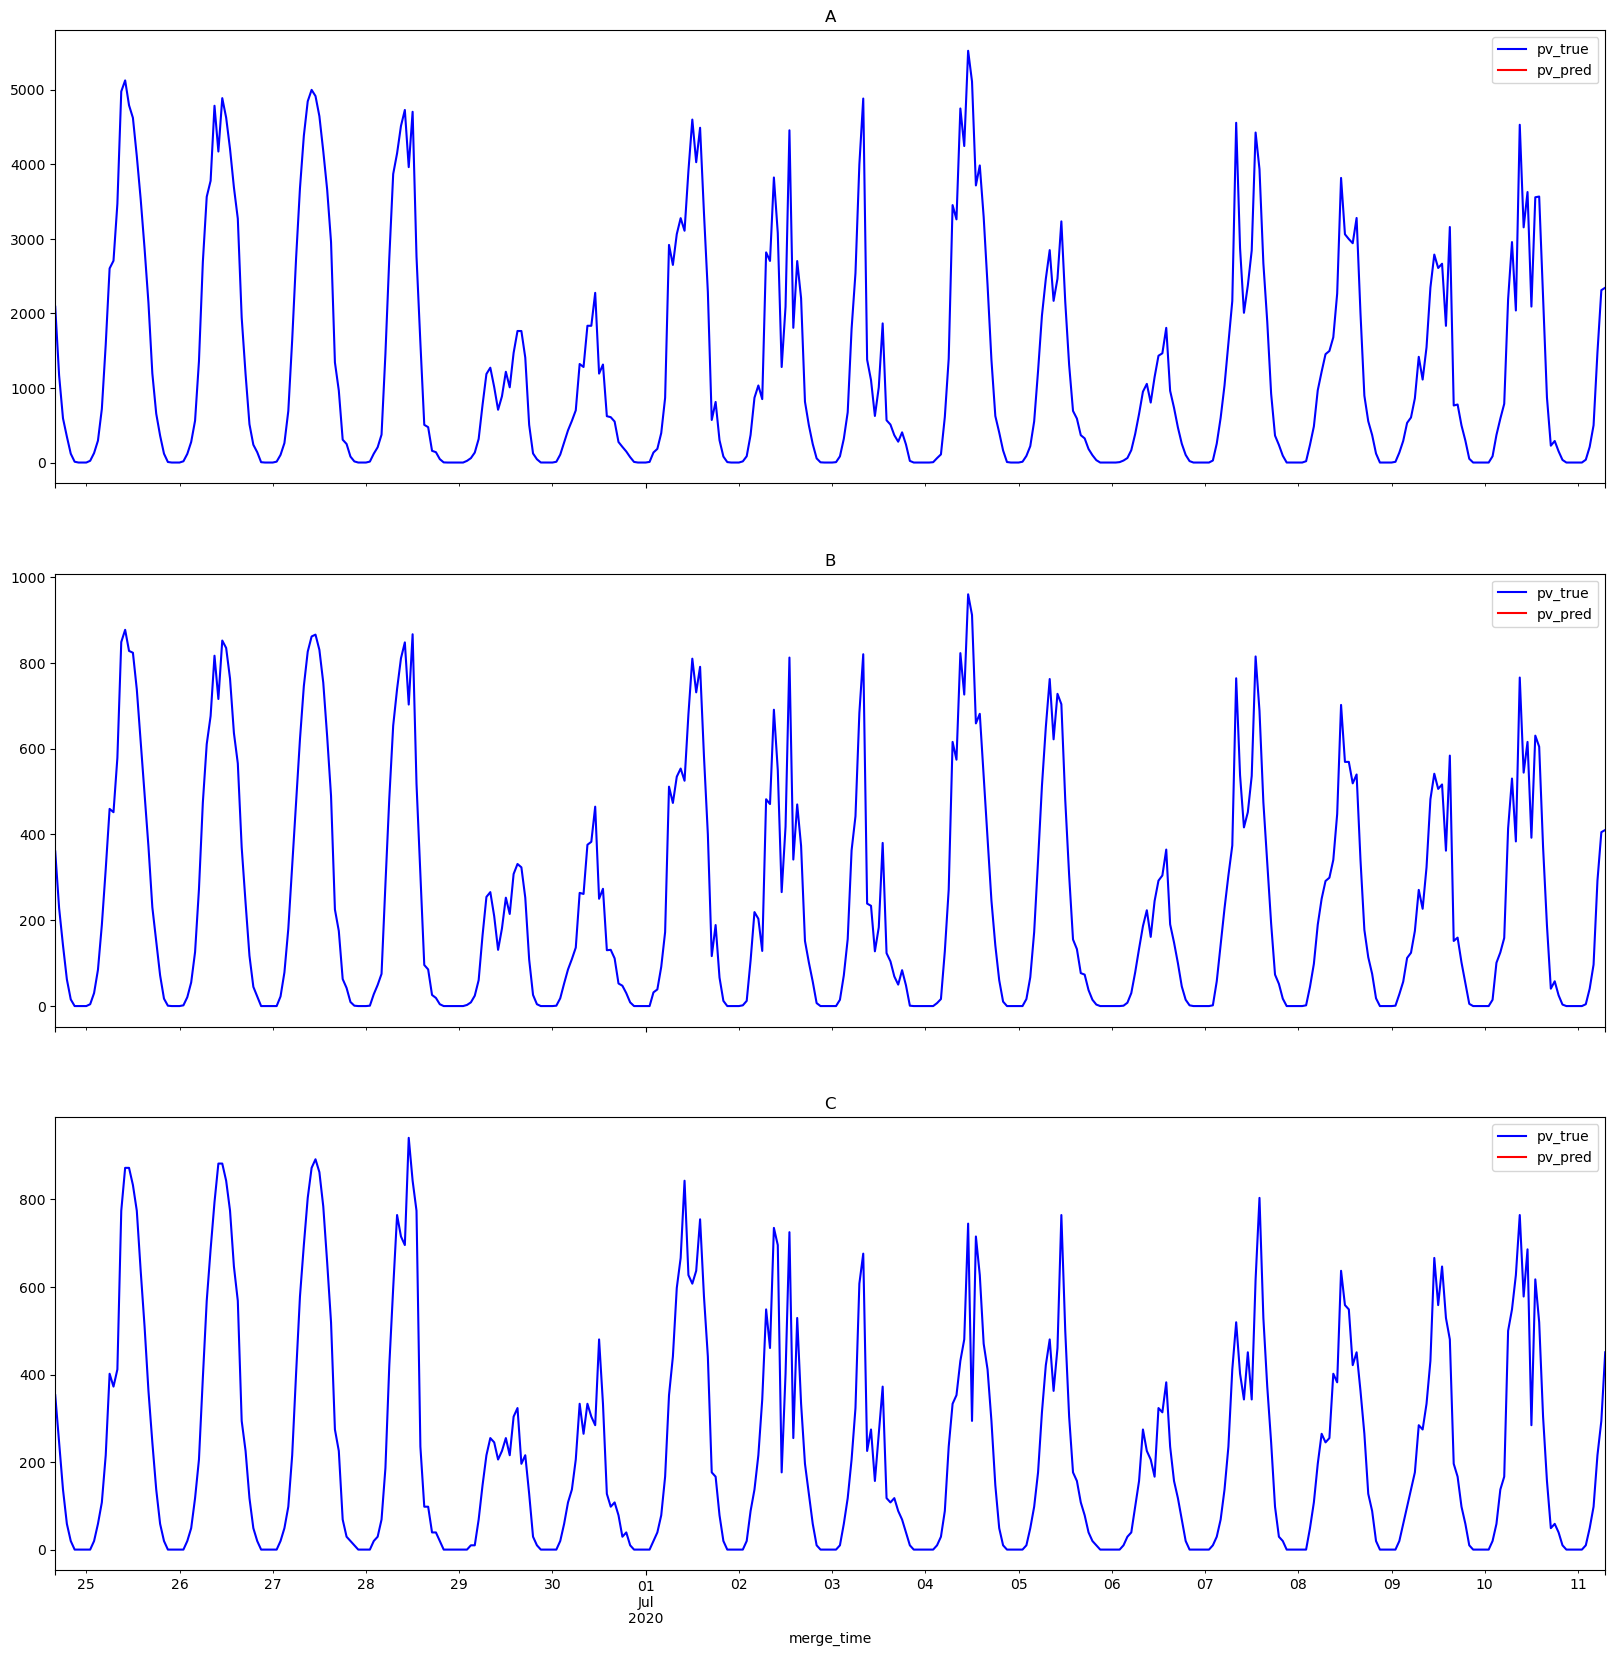

In [27]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20), sharex=True)

comparisonA.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[0], title='A', color='blue')
comparisonA.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[0], title='A', color='red')
comparisonB.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[1], title='B', color='blue')
comparisonB.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[1], title='B', color='red')
comparisonC.iloc[-400:][['merge_time', 'pv_true']].set_index('merge_time').plot(ax=axs[2], title='C', color='blue')
comparisonC.iloc[-400:][['merge_time', "pv_pred"]].set_index('merge_time').plot(ax=axs[2], title='C', color='red')